In [1]:
import sys
import os
import numpy as np


### Add src directory

In [2]:
# current path is /Users/axhome/AX/MASTER/Courses/DD2424/DD2424-DeepLearning/Assignment1/notebooks
# we want to add the path /Users/axhome/AX/MASTER/Courses/DD2424/DD2424-DeepLearning/Assignment1/src

# add the path to the sys.path
# sys.path.append('/Users/axhome/AX/MASTER/Courses/DD2424/DD2424-DeepLearning/Assignment1/src')
# or use os.path.abspath
sys.path.append(os.path.abspath("../src"))


### Import functions from src files

In [3]:
from data_loader import LoadBatch
from preprocessing import reshape_images, normalize_images
from torch_gradient_computations import ComputeGradsWithTorch



# Exercise - Training a multi-linear classifier

## Task 1 
**Write a function that reads in the data from a CIFAR-10 batch file and returns the image and label data in separate files.**

In [4]:
X, Y, y = LoadBatch(1)
print(X.shape)

(3072, 10000)


In [5]:
print(Y[:, 0])

[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [6]:
print(y[0])

[6 9 9 ... 1 1 5]


#### Read in Train, Validation and Test data

In [7]:
X_train_raw, Y_train, y_train = LoadBatch(1)
X_val_raw, Y_val, y_val = LoadBatch(2)
X_test_raw, Y_test, y_test = LoadBatch("test_batch")

## Task 2
**pre-process the raw input data**

Compute the mean and standard deviation vector for the
training data and then normalize the training, validation and test data
w.r.t. the training mean and standard deviation vectors.

In [8]:
# transform training data to have zero mean

X_train_mean = np.mean(X_train_raw, axis=1).reshape(-1, 1) # (3072, 1)
X_train_std = np.std(X_train_raw, axis=1).reshape(-1, 1) # (3072, 1)

In [9]:
# normalize the data

# Training data
X_train = X_train_raw - X_train_mean
X_train = X_train / X_train_std

# Validation data
X_val = X_val_raw - X_train_mean
X_val = X_val / X_train_std

# Testing data
X_test = X_test_raw - X_train_mean
X_test = X_test / X_train_std



In [10]:
y_train.shape

(1, 10000)

## Task 3
**Initialise the parameters of the model W (Kxd) and b (Kx1)**

In [11]:
# Random number generation
rng = np.random.default_rng()

# Get the BitGenerator used by deault_rng
#PCG64
BitGen = type(rng.bit_generator)

# use the state from a fresh bit generator 
seed = 42

# dimensions
K = 10 
d = 3072

# set the state of the bit generator
rng.bit_generator.state = BitGen(seed).state

# initialize the network
init_net = {}
init_net["W"] = 0.01*rng.standard_normal(size = (K, d))
init_net["b"] = np.zeros((K, 1))

## Task 4
**Write a function that applies the network function, (i.e. equations 1 and 2) to multiple images and returns the results**

$$
\mathbf{s} = \mathbf{W} \mathbf{x} + \mathbf{b} \quad (1)
$$

$$
\mathbf{p} = \text{SOFTMAX}(\mathbf{s}) \quad (2)
$$


In [12]:
X_train.shape

(3072, 10000)

In [13]:
X_train[:,1].shape

(3072,)

In [14]:
# write function P = ApplyNetwork(X, net)
# def ApplyNetwork(X, net):
#     W = net["W"]
#     b = net["b"]
#     P = W @ X + b
#     return P

# import numpy as np

def softmax(S):
    """
    Computes column-wise softmax of S, where S is K x N.
    Returns a K x N matrix of probabilities.
    """
    S_shifted = S - np.max(S, axis=0, keepdims=True)  # Numerical stability
    exp_S = np.exp(S_shifted)
    return exp_S / np.sum(exp_S, axis=0, keepdims=True)

def ApplyNetwork(X, net):
    """
    Applies the network function: Computes class scores and applies softmax.
    
    Parameters:
      X   : d x N array of input images (each column is an image)
      net : Dictionary containing network parameters
            net["W"] (K x d) - Weight matrix
            net["b"] (K x 1) - Bias vector
    
    Returns:
      P : K x N matrix of class probabilities after softmax
    """
    W = net["W"]
    b = net["b"]
    
    S = W @ X + b  # Compute raw class scores
    P = softmax(S)  # Apply softmax to get probabilities
    return P



In [15]:
P = ApplyNetwork(X_train[:, 0:20], init_net)

In [16]:
P.shape

(10, 20)

## Task 5 
**Write the function that computes the loss function given by equation (5) for a set of images**

$$
J(\mathcal{D}, \lambda, \mathbf{W}, \mathbf{b}) =
\frac{1}{|\mathcal{D}|} \sum_{(\mathbf{x}, \mathbf{y}) \in \mathcal{D}}
l_{\text{cross}} (\mathbf{x}, \mathbf{y}, \mathbf{W}, \mathbf{b})
+ \lambda \sum_{i,j} W_{ij}^{2} \quad \quad \quad (5)
$$


In [17]:
def ComputeLoss(P, y, W, lam):
    """
    Computes the cost function J using softmax probabilities.
    
    Parameters:
      P   : K x N matrix of softmax probabilities
      y   : 1D array of length N with ground truth class indices (integers 0 to 9)
      W   : K x d weight matrix (needed for regularization term)
      lam : Regularization coefficient (float)
    
    Returns:
      J : Scalar value representing the total loss (cross-entropy + regularization)
    """
    # Number of training examples
    N = P.shape[1]

    # Pick correct class probabilities for each example using indexing
    # Example P[y=5,Sample1] is the probability of class 5 for the first example
    log_probs = -np.log(P[y, np.arange(N)] + 1e-15)  # Avoid log(0) 
    
    # Cross-entropy loss (mean over all examples)
    cross_entropy_loss = np.mean(log_probs)

    # Regularization term (L2 penalty on W)
    reg_term = lam * np.sum(W**2)

    # Total cost
    J = cross_entropy_loss + reg_term
    
    return J

In [18]:
L = ComputeLoss(P, y_train[0][0:20], init_net["W"], 0.1)

In [19]:
L

2.6269273667412074

## Task 6
**Write a function that computes the accuracy of the network’s predic-
tions given by equation (4) on a set of data**

$$
k^* = \arg\max\limits_{1 \leq k \leq K} \{p_1, \dots, p_K\}
$$



In [ ]:
def ComputeAccuracy(P, y):
    """
    Computes the classification accuracy of the network.
    
    Parameters:
      P : K x N matrix of softmax probabilities (each column sums to 1)
      y : 1D array of length N containing ground truth class indices (0 to K-1)
    
    Returns:
      accuracy : Scalar value representing the accuracy percentage
    """
    # Get the predicted class index for each image (argmax over K classes)
    y_pred = np.argmax(P, axis=0)  # Shape: (N,)

    # Compute the percentage of correct predictions
    accuracy = np.mean(y_pred == y) * 100  # Convert to percentage
    
    
    return accuracy


In [21]:

acc = ComputeAccuracy(P, y_train[0][0:20])

In [22]:
acc

20.0

## Task 7
**Write the function that evaluates, for a mini-batch, the gradients of the
cost function w.r.t. W and b, that is equations (10, 11).**


#### Gradient Equations

The partial derivatives of the objective function $ J $ with respect to $ W $ and $ b $ are given by:

$$
\frac{\partial J(\mathcal{B}^{(t+1)}, \lambda, W, b)}{\partial W} =
\frac{1}{|\mathcal{B}^{(t+1)}|} \sum_{(\mathbf{x}, y) \in \mathcal{B}^{(t+1)}}
\frac{\partial \mathcal{L}_{\text{cross}}(\mathbf{x}, y, W, b)}{\partial W} + 2\lambda W
\quad (10)
$$

$$
\frac{\partial J(\mathcal{B}^{(t+1)}, \lambda, W, b)}{\partial b} =
\frac{1}{|\mathcal{B}^{(t+1)}|} \sum_{(\mathbf{x}, y) \in \mathcal{B}^{(t+1)}}
\frac{\partial \mathcal{L}_{\text{cross}}(\mathbf{x}, y, W, b)}{\partial b}
\quad (11)
$$




In [23]:
def BackwardPass(X, Y, P, network, lam):
    """
    Computes gradients of the cost function J with respect to W and b.

    Parameters:
      X      : d x N input data matrix (each column is an image)
      Y      : K x N one-hot ground truth labels
      P      : K x N softmax probabilities from ApplyNetwork
      network: Dictionary containing model parameters:
               - "W": K x d weight matrix
               - "b": K x 1 bias vector
      lam    : Regularization coefficient

    Returns:
      grads: Dictionary with gradients
             - "W": K x d gradient matrix
             - "b": K x 1 gradient vector
    """
    N = X.shape[1]  # Number of samples in mini-batch

    # Compute gradient of the loss w.r.t. S (logits)
    G = P - Y  # (K x N)

    # Compute gradients
    grad_W = (1 / N) * (G @ X.T) + 2 * lam * network["W"]  # (K x d)
    grad_b = (1 / N) * np.sum(G, axis=1, keepdims=True)     # (K x 1)

    # Store gradients in a dictionary
    grads = {
        "W": grad_W,
        "b": grad_b
    }
    
    return grads


In [24]:
# Forward pass
P = ApplyNetwork(X, init_net)

# Compute gradients
grads = BackwardPass(X, Y, P, init_net, 0.1)

print("Gradient of W shape:", grads["W"].shape)  # Should be (K, d)
print("Gradient of b shape:", grads["b"].shape)  # Should be (K, 1)

Gradient of W shape: (10, 3072)
Gradient of b shape: (10, 1)


In [25]:
d_small = 10
n_small = 3
lam = 0
small_net = {}
small_net['W'] = .01*rng.standard_normal(size = (10, d_small))
small_net['b'] = np.zeros((10, 1))
X_small = X_train[0:d_small, 0:n_small]
Y_small = Y_train[:, 0:n_small]
P = ApplyNetwork(X_small, small_net)
my_grads = BackwardPass(X_small, Y_small, P, small_net, lam)
torch_grads = ComputeGradsWithTorch(X_small, y_train[0][0:n_small], small_net)

TypeError: ComputeGradsWithTorch() missing 1 required positional argument: 'lam'

In [ ]:
def CompareGradients(dict1, dict2, tolerance=1e-6):
    """
    Compares two dictionaries containing gradients and returns the values
    where the absolute difference is greater than the specified tolerance.

    Parameters:
      dict1 : dict
          First dictionary containing gradients.
      dict2 : dict
          Second dictionary containing gradients.
      tolerance : float
          The threshold for considering two values as different.

    Returns:
      differences : dict
          A dictionary containing the keys and the corresponding values
          where the absolute difference is greater than the tolerance.
    """
    differences = {}
    for key in dict1:
        diff = np.abs(dict1[key] - dict2[key])
        if np.any(diff > tolerance):
            differences[key] = diff[diff > tolerance]

    if len(differences) == 0:
        print("Gradients match within the specified tolerance.")
        return None
    else:
        print(f"Number of gradients that differ: {len(differences)}")
        print(f"Max difference: {np.max([np.max(diff) for diff in differences.values()])}")

        return differences

In [ ]:
diff = CompareGradients(my_grads, torch_grads)

Gradients match within the specified tolerance.


## Task 8
**Write the code to perform the mini-batch gradient descent algorithm
to learn the network’s parameters where the updates are defined in
equations (8, 9)**

#### Weight and Bias Update Equations

$$
W^{(t+1)} = W^{(t)} - \eta \frac{\partial J(\mathcal{B}^{(t+1)}, \lambda, W, \mathbf{b})}{\partial W} \bigg|_{W = W^{(t)}, \mathbf{b} = \mathbf{b}^{(t)}}
\quad (8)
$$

$$
\mathbf{b}^{(t+1)} = \mathbf{b}^{(t)} - \eta \frac{\partial J(\mathcal{B}^{(t+1)}, \lambda, W, \mathbf{b})}{\partial \mathbf{b}} \bigg|_{W = W^{(t)}, \mathbf{b} = \mathbf{b}^{(t)}}
\quad (9)
$$


In [ ]:


def MiniBatchGD(X, Y, GDparams, init_net, lam):
    """
    Performs Mini-Batch Gradient Descent to train the network.

    Parameters:
      X        : d x N input data matrix (each column is an image)
      Y        : K x N one-hot ground truth labels
      GDparams : Dictionary containing:
                 - "n_batch": Mini-batch size
                 - "eta": Learning rate
                 - "n_epochs": Number of epochs
      init_net : Dictionary containing initial parameters:
                 - "W": K x d weight matrix
                 - "b": K x 1 bias vector
      lam      : Regularization coefficient

    Returns:
      trained_net : Dictionary with the learned parameters:
                    - "W": Trained weight matrix
                    - "b": Trained bias vector
    """
    # Make a deep copy to avoid modifying the original dictionary
    trained_net = copy.deepcopy(init_net)

    # Extract hyperparameters
    n_batch = GDparams["n_batch"]
    eta = GDparams["eta"]
    n_epochs = GDparams["n_epochs"]
    
    N = X.shape[1]  # Total number of samples
    rng = np.random.default_rng(seed=42)  # Ensure reproducibility

    for epoch in range(n_epochs):
        # Shuffle the training data
        shuffled_indices = rng.permutation(N)
        X_shuffled = X[:, shuffled_indices]
        Y_shuffled = Y[:, shuffled_indices]

        # Mini-Batch Gradient Descent
        for j in range(N // n_batch):
            j_start = j * n_batch
            j_end = (j + 1) * n_batch
            Xbatch = X_shuffled[:, j_start:j_end]  # Mini-batch inputs (d x n_batch)
            Ybatch = Y_shuffled[:, j_start:j_end]  # Mini-batch labels (K x n_batch)

            # Forward pass: Compute softmax probabilities
            P = ApplyNetwork(Xbatch, trained_net)

            # Compute gradients
            grads = BackwardPass(Xbatch, Ybatch, P, trained_net, lam)

            # Update parameters using Gradient Descent:
            trained_net["W"] -= eta * grads["W"]
            trained_net["b"] -= eta * grads["b"]

        # Compute and print the loss at the end of each epoch
        P_train = ApplyNetwork(X, trained_net)
        loss = ComputeLoss(P_train, np.argmax(Y, axis=0), trained_net["W"], lam)
        print(f"Epoch {epoch+1}/{n_epochs} - Loss: {loss:.4f}")

    return trained_net


In [36]:
trained_net = MiniBatchGD(X_train, Y_train, {"n_batch": 100, "eta": 0.01, "n_epochs": 10}, init_net, 0.1)

Epoch 1/10 - Loss: 2.0191
Epoch 2/10 - Loss: 1.8965
Epoch 3/10 - Loss: 1.8236
Epoch 4/10 - Loss: 1.8029
Epoch 5/10 - Loss: 1.7753
Epoch 6/10 - Loss: 1.7688
Epoch 7/10 - Loss: 1.7647
Epoch 8/10 - Loss: 1.7460
Epoch 9/10 - Loss: 1.7351
Epoch 10/10 - Loss: 1.7264


In [33]:
# Compute the accuracy on the training set
P_train = ApplyNetwork(X_train, trained_net)
acc_train = ComputeAccuracy(P_train, y_train)
print(f"Training accuracy: {acc_train:.2f}%")

Training accuracy: 44.73%


In [38]:

import matplotlib.pyplot as plt

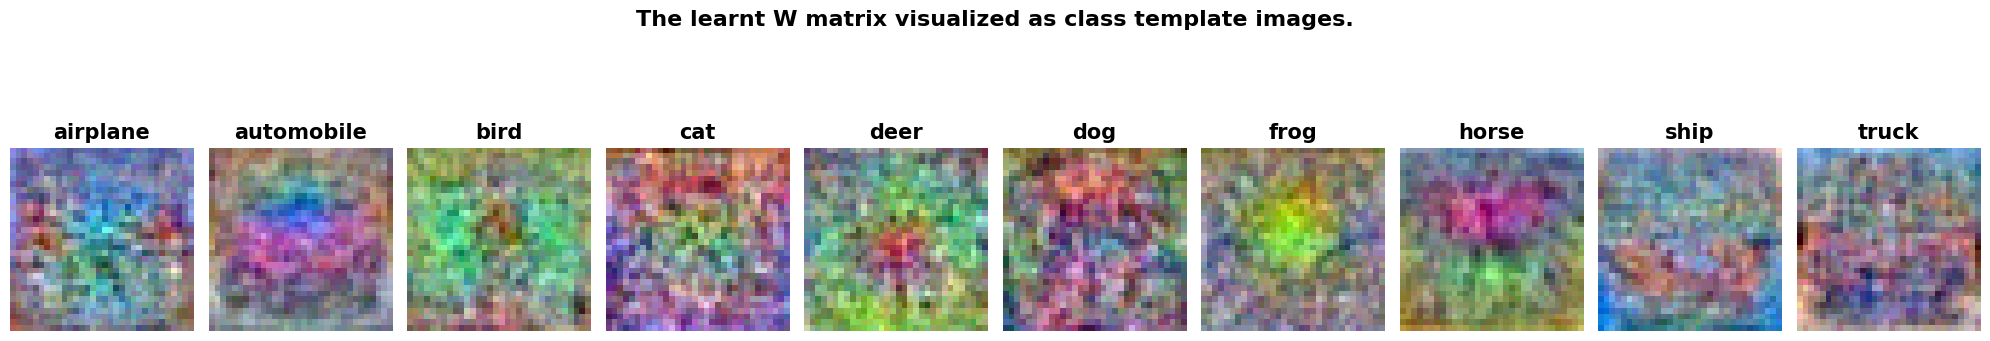

In [ ]:
def visualize_W_matrix(trained_net, class_names, save_path="../results/images/W_matrix.png"):
    """
    Visualizes the learnt W matrix as class template images.

    Parameters:
        trained_net : dict
            Dictionary containing the trained network parameters.
        class_names : list
            List of class names corresponding to the CIFAR-10 dataset.
        save_path : str
            Path to save the visualized W matrix image.
    """
    plt.figure(figsize=(20, 4))  # Increase the figure size
    plt.suptitle("The learnt W matrix visualized as class template images.", fontsize=16, fontweight='bold')

    Ws = trained_net['W'].T.reshape((32, 32, 3, 10), order='F')
    W_im = np.transpose(Ws, (1, 0, 2, 3))

    for i in range(10):
        w_im = W_im[:, :, :, i]
        w_im_norm = (w_im - np.min(w_im)) / (np.max(w_im) - np.min(w_im))
        plt.subplot(1, 10, i + 1)
        plt.imshow(w_im_norm, interpolation='nearest')
        plt.axis('off')
        plt.title(class_names[i], fontsize=15, fontweight='bold')

    plt.tight_layout(rect=[0, 0, 1, 0.9])  # Adjust layout to fit the title
    plt.savefig(save_path)
    print(f"Visualization saved to {save_path}")

# Run the function
class_names = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]
visualize_W_matrix(trained_net, class_names)
